<a href="https://colab.research.google.com/github/cgyireh1/API_Assignment/blob/main/SickleClinix_model_training_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SickleClinix

In [48]:
# import necessary libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [49]:
# Define path to dataset
data_dir = '/content/drive/MyDrive/CAPSTONE/sickle-data-augmented/Augmented-Sorted'

# Get class names from data
class_names = sorted(os.listdir(data_dir))
print(f"Classes found: {class_names}")

# Count images per class
for label in class_names:
    count = len(os.listdir(os.path.join(data_dir, label)))
    print(f"{label}: {count} images")


Classes found: ['Normal', 'Sickle']
Normal: 1147 images
Sickle: 1844 images


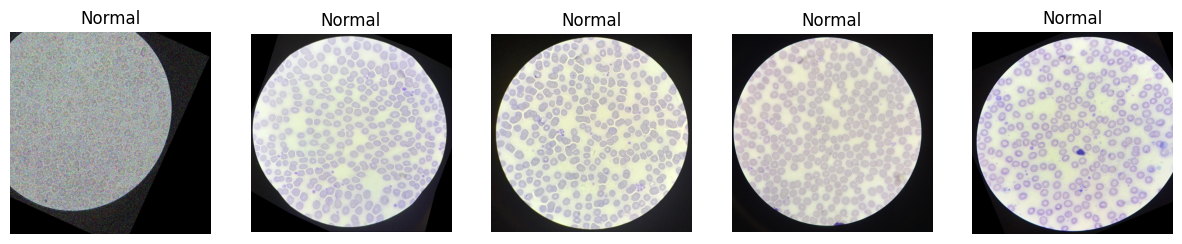

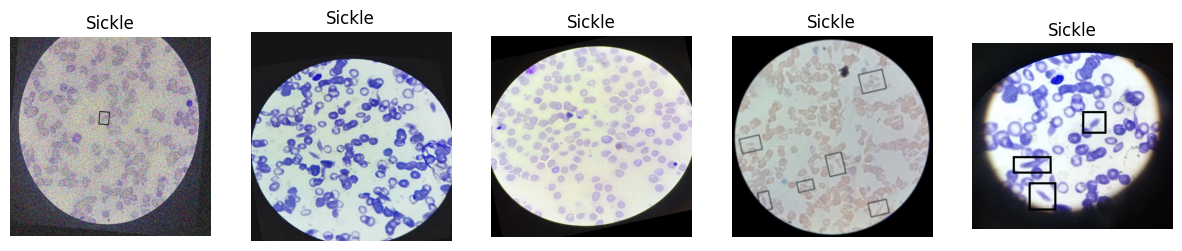

In [50]:
# Display sample images
def show_sample_images(class_name, n=3):
    img_paths = glob(os.path.join(data_dir, class_name, '*.jpg')) # used only .jpg because all the images are in jpg
    sample_paths = random.sample(img_paths, n) # n = number of samples to be displayed

    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')
    plt.show()

# Show samples
for cls in class_names:
    show_sample_images(cls, n=5)

## Dataset Balancing and Preprocessing

**The dataset is imbalanced:** To reduce that, I applied undersampling to the "Sickle" class so that both classes have the same number of images (1147 each) and the model does not become biased toward the majority class.


In [51]:
# Function to collect image file paths and labels
def get_image_paths_and_labels(base_dir):
    data = []
    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        for file in os.listdir(label_dir):
            if file.lower().endswith(('jpg')):
                data.append((os.path.join(label_dir, file), label))
    return pd.DataFrame(data, columns=["filepath", "label"])

df = get_image_paths_and_labels(data_dir)

# Undersample the majority class (Sickle)
min_class_size = df['label'].value_counts().min()
balanced_df = (
    df.groupby("label")
    .apply(lambda x: x.sample(min_class_size, random_state=42))
    .reset_index(drop=True)
)

<ipython-input-51-c7c9a3ab154a>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_class_size, random_state=42))


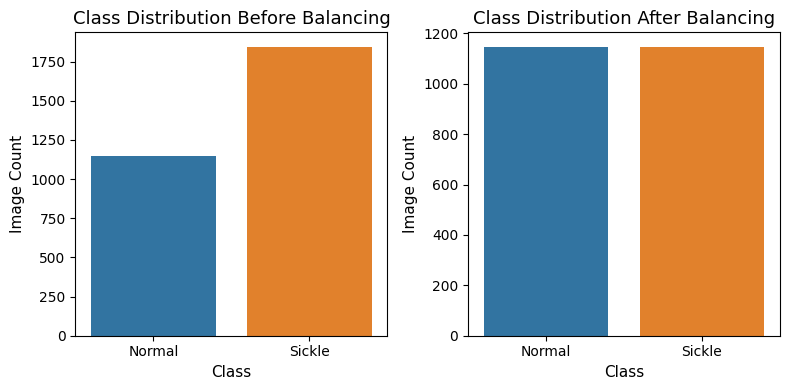

In [52]:
# Class distribution visualizations
custom_palette = {
    "Normal": "#1f77b4",
    "Sickle": "#ff7f0e"
}

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Before balancing
sns.countplot(data=df, x='label', hue='label', palette=custom_palette, ax=axes[0], legend=False)
axes[0].set_title("Class Distribution Before Balancing", fontsize=13)
axes[0].set_xlabel("Class", fontsize=11)
axes[0].set_ylabel("Image Count", fontsize=11)

# After balancing
sns.countplot(data=balanced_df, x='label', hue='label', palette=custom_palette, ax=axes[1], legend=False)
axes[1].set_title("Class Distribution After Balancing", fontsize=13)
axes[1].set_xlabel("Class", fontsize=11)
axes[1].set_ylabel("Image Count", fontsize=11)

plt.tight_layout()
plt.show()


These bar charts show the number of images per class before and after balancing:

**Before Balancing**: The *Sickle* class had more examples than *Normal*.

**After Balancing**: We now have an equal number of samples in each class (1147 each), which ensures fairer model training and better generalization across all the classes.


### Data Splitting
We split the dataset into training (70%), validation (15%), and test (15%) sets, ensuring class balance in each split.

In [53]:
# Split into train, val, test sets
train_df, temp_df = train_test_split(
    balanced_df, test_size=0.3, stratify=balanced_df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Training samples: 1605
Validation samples: 344
Test samples: 345


**Set up the data generators**
The data generators normalize pixel values and prepare batches of images for training, validation, and testing. The classes are automatically mapped as follows:
- Normal → 0
- Sickle → 1

In [54]:
# Image preprocessing parameters
image_size = (224, 224)
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)

# Training Data Generator
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Test Data Generator
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Save class indices for decoding predictions
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)




# We do not shuffle validation data to ensures stable evaluation and test data to ensure correct label matching

Found 1605 validated image filenames belonging to 2 classes.
Found 344 validated image filenames belonging to 2 classes.
Found 345 validated image filenames belonging to 2 classes.
Class Indices: {'Normal': 0, 'Sickle': 1}


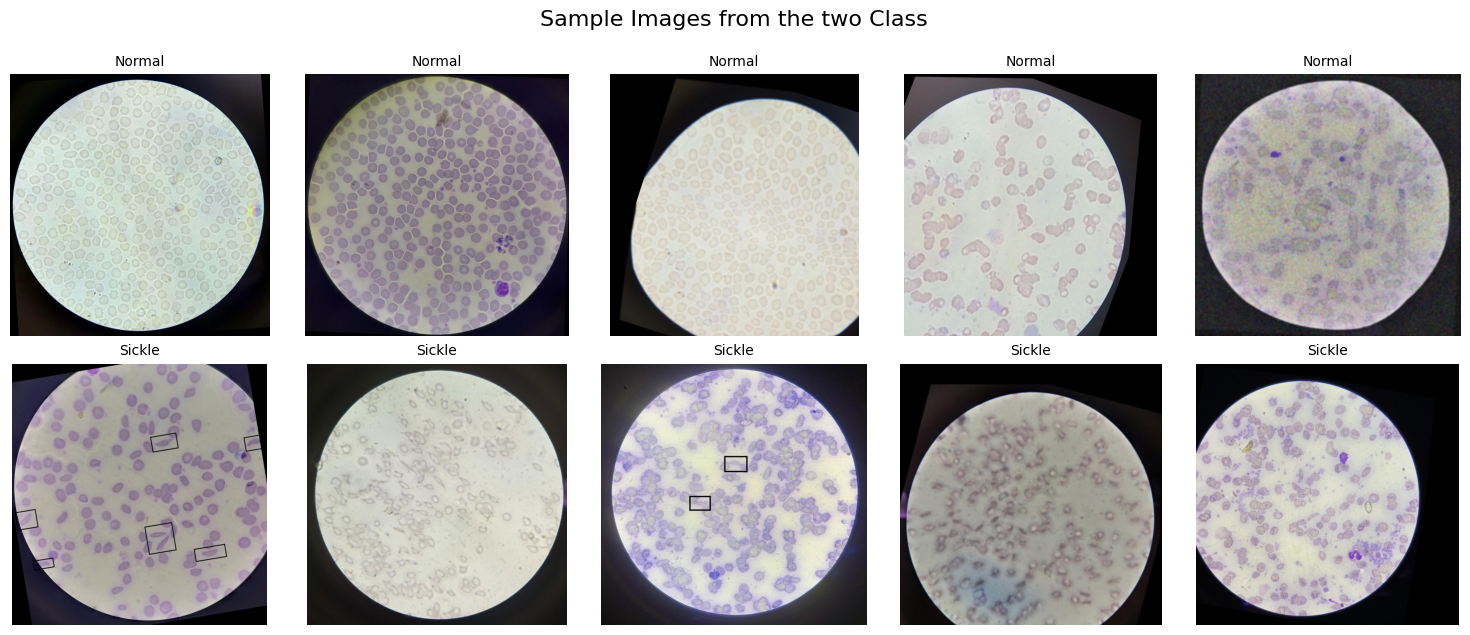

In [55]:
# Set class directories
classes = ['Normal', 'Sickle']

# Show 5 images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for row_idx, label in enumerate(classes):
    class_path = os.path.join(data_dir, label)
    samples = random.sample(os.listdir(class_path), 5)

    for col_idx, img_name in enumerate(samples):
        img_path = os.path.join(class_path, img_name)
        image = Image.open(img_path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].axis("off")
        axes[row_idx, col_idx].set_title(f"{label}", fontsize=10)

plt.tight_layout()
plt.suptitle("Sample Images from the two Class", fontsize=16, y=1.05)
plt.show()

##**Model Training**

### 1. MobileNetV2

In [56]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_path = "mobilenetv2_best_model.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
]

# save model architecture
plot_model(model, to_file="mobilenetv2_model.png", show_shapes=True, show_layer_names=True)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,273 (9.27 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 819ms/step - accuracy: 0.6661 - loss: 0.5959 - val_accuracy: 0.8808 - val_loss: 0.3441
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 628ms/step - accuracy: 0.8886 - loss: 0.3268 - val_accuracy: 0.9273 - val_loss: 0.2391
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 605ms/step - accuracy: 0.8897 - loss: 0.2702 - val_accuracy: 0.9390 - val_loss: 0.2010
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 625ms/step - accuracy: 0.9085 - loss: 0.2279 - val_accuracy: 0.9419 - val_loss: 0.1789
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 606ms/step - accuracy: 0.9240 - loss: 0.2003 - val_accuracy: 0.9419 - val_loss: 0.1650
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 619ms/step - accuracy: 0.9216 - loss: 0.1970 - val_accuracy: 0.9506 - val_loss: 0.1527
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 637ms/step - accuracy: 0.9225 - loss: 0.1815 - val_accuracy: 0.9593 - val_loss: 0.1395
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 608ms/step - accuracy: 0.9487 - loss: 0.1558 - val_accu

### 2. EfficientNetB0

In [58]:
# Load base model EfficientNetB0 without top, pretrained on ImageNet
base_model_eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model_eff.trainable = False

# Build model
efficientnet_model = models.Sequential([
    base_model_eff,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

efficientnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

efficientnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,221,860 (16.11 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [59]:
# Train EfficientNet
history_effnet = efficientnet_model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=10,
  callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 71s 981ms/step - accuracy: 0.5086 - loss: 0.6999 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 54s 624ms/step - accuracy: 0.4995 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 621ms/step - accuracy: 0.4999 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 606ms/step - accuracy: 0.5159 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 610ms/step - accuracy: 0.5096 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 628ms/step - accuracy: 0.4891 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 607ms/step - accuracy: 0.5050 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 610ms/step - accuracy: 0.4877 - loss: 0.6942 - val_accu

### 3. ResNet50

In [60]:
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model_res.trainable = False

resnet_model = models.Sequential([
    base_model_res,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [61]:
# Train ResNet50
history_resnet = resnet_model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=10,
  callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 53s 810ms/step - accuracy: 0.5114 - loss: 0.7403 - val_accuracy: 0.5407 - val_loss: 0.6853
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 718ms/step - accuracy: 0.5413 - loss: 0.6898 - val_accuracy: 0.6395 - val_loss: 0.6758
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 612ms/step - accuracy: 0.5747 - loss: 0.6813 - val_accuracy: 0.7180 - val_loss: 0.6685
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 717ms/step - accuracy: 0.5935 - loss: 0.6740 - val_accuracy: 0.6512 - val_loss: 0.6593
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 620ms/step - accuracy: 0.6044 - loss: 0.6651 - val_accuracy: 0.7384 - val_loss: 0.6477
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 33s 649ms/step - accuracy: 0.6753 - loss: 0.6320 - val_accuracy: 0.7413 - val_loss: 0.6309
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 624ms/step - accuracy: 0.6909 - loss: 0.6209 - val_accuracy: 0.7267 - val_loss: 0.6131
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 625ms/step - accuracy: 0.6758 - loss: 0.6101 - val_accu

## Comparing The Models

In [62]:
# Evaluate on test set
mobilenet_eval = model.evaluate(test_generator)
efficientnet_eval = efficientnet_model.evaluate(test_generator)
resnet_eval = resnet_model.evaluate(test_generator)

print("MobileNetV2 Test Accuracy:", mobilenet_eval[1])
print("EfficientNetB0 Test Accuracy:", efficientnet_eval[1])
print("ResNet50 Test Accuracy:", resnet_eval[1])

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.9724 - loss: 0.1113
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 838ms/step - accuracy: 0.4793 - loss: 0.6932
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 636ms/step - accuracy: 0.7640 - loss: 0.5221
MobileNetV2 Test Accuracy: 0.9449275135993958
EfficientNetB0 Test Accuracy: 0.5014492869377136
ResNet50 Test Accuracy: 0.7362318634986877


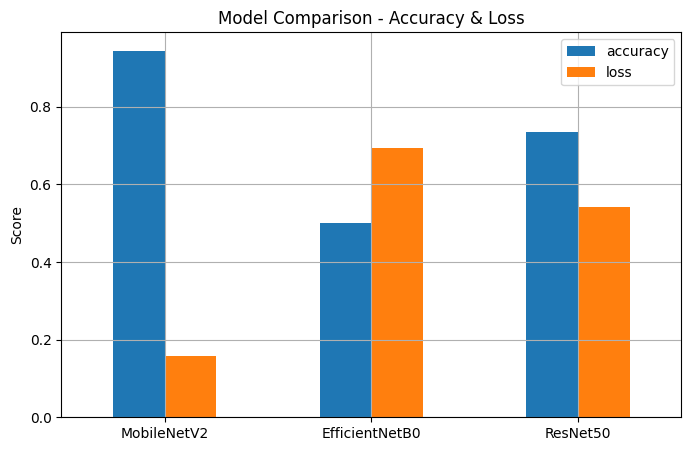

In [63]:
results = {
    "MobileNetV2": {"accuracy": mobilenet_eval[1], "loss": mobilenet_eval[0]},
    "EfficientNetB0": {"accuracy": efficientnet_eval[1], "loss": efficientnet_eval[0]},
    "ResNet50": {"accuracy": resnet_eval[1], "loss": resnet_eval[0]},
}

df_results = pd.DataFrame(results).T
df_results.plot(kind='bar', figsize=(8, 5))
plt.title("Model Comparison - Accuracy & Loss")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### Learning Curves for the best Model

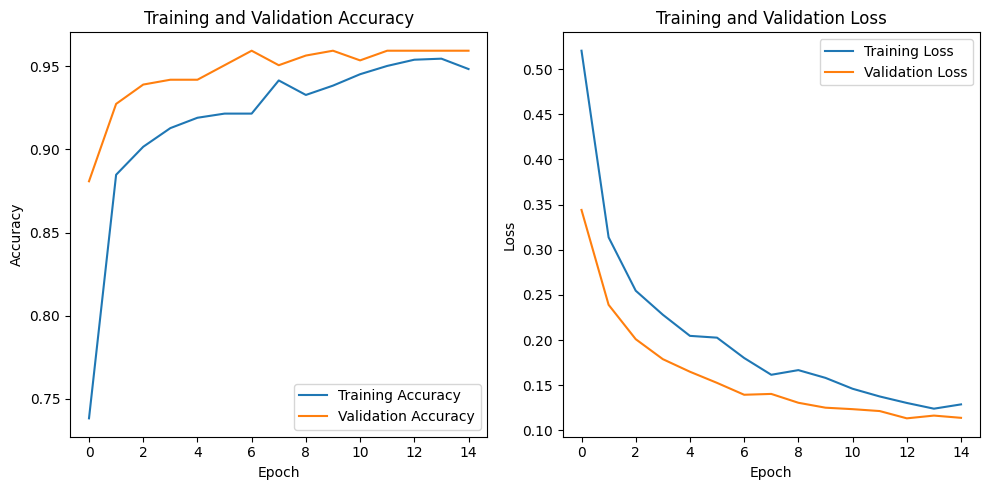

In [64]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)


### Test Evaluation

In [65]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - accuracy: 0.9724 - loss: 0.1113
Test Accuracy: 0.9449
Test Loss: 0.1591


In [66]:
# Predict on test set
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 696ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.95      0.95       173
      Sickle       0.95      0.94      0.94       172

    accuracy                           0.94       345
   macro avg       0.95      0.94      0.94       345
weighted avg       0.95      0.94      0.94       345



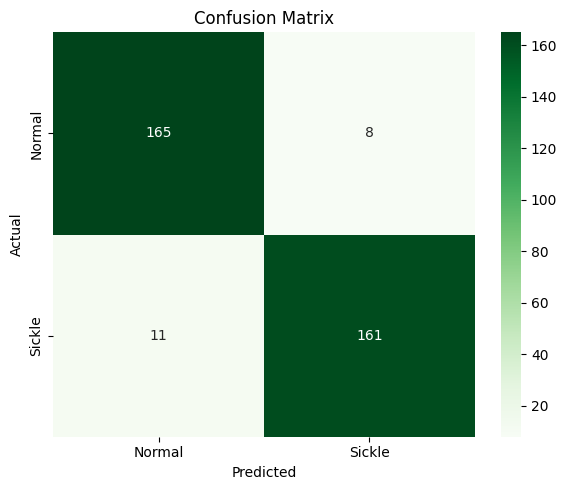

In [67]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_indices.keys(),
            yticklabels=class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### AUC(Receiver-operating characteristic) - ROC(Area Under the Curve)
AUC-ROC curve helps us to understand how well the model separates the positive cases like people with a sickle from the negative cases like people without the it at different threshold level.



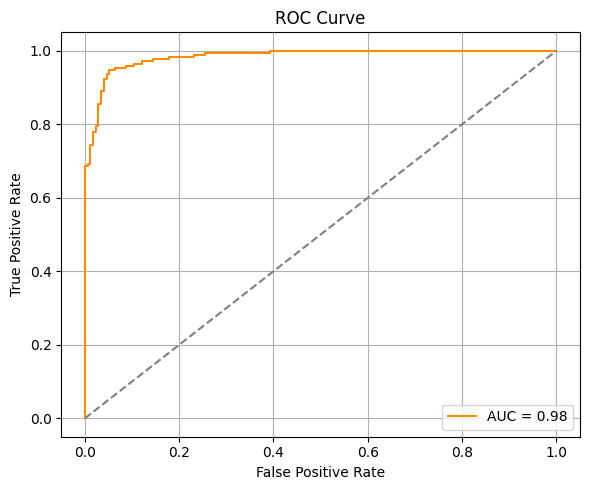

In [72]:
# ROC and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

A higher AUC value indicates better model performance as it suggests a greater ability to distinguish between classes. An AUC value of 1.0 indicates perfect performance while 0.5 suggests it is random guessing. (GeeksforGeeks, 2023)

and hence AUC = 0.99 shows the model is generalizing and predicting well

### Misclassification Analysis

In [73]:
# Results DataFrame
results_df = pd.DataFrame({
    'True Label': y_true,
    'Predicted Label': y_pred
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

# Count number of correct and incorrect predictions
correct_counts = results_df['Correct'].value_counts()

print("Number of Correct Predictions:", correct_counts.get(True, 0))
print("Number of Incorrect Predictions:", correct_counts.get(False, 0))
print('\n', results_df.tail(10))

Number of Correct Predictions: 326
Number of Incorrect Predictions: 19

      True Label  Predicted Label  Correct
335           0                0     True
336           0                0     True
337           0                0     True
338           0                0     True
339           1                1     True
340           1                1     True
341           0                0     True
342           0                0     True
343           1                1     True
344           0                0     True


Total misclassified images: 19




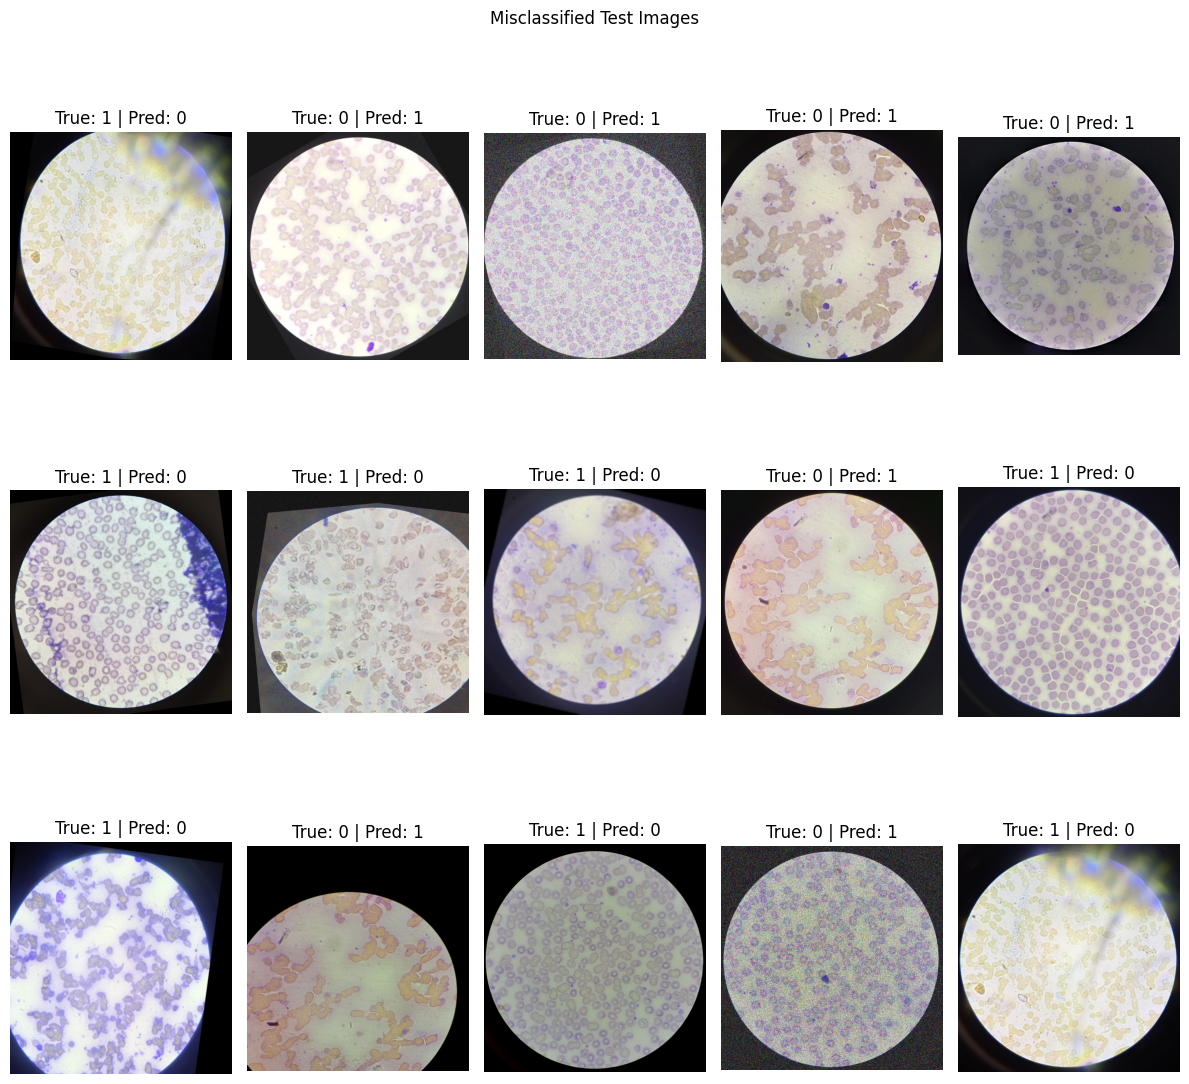

In [74]:
# image confirmation of misclassification

# Get filenames
file_paths = test_generator.filepaths

# Misclassified indices
misclassified_idx = np.where(y_pred != y_true)[0]
print(f"Total misclassified images: {len(misclassified_idx)}\n\n")

# Display some misclassified images
plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_idx[:15]):
    img = mpimg.imread(file_paths[idx])
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
plt.suptitle("Misclassified Test Images")
plt.tight_layout()
plt.show()


### **Grad-CAM** (Gradient-weighted Class Activation Mapping)

They are used to generate heatmaps which highlights the important region of the image that contribute the way a model performs as it does. (Muskan, B., 2021)

In [75]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Get the base model
    base_model = model.layers[0]

    # Create a model that maps the input image to the last conv layer and the output
    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, 0]

    # Compute gradients of the class output value
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps by gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


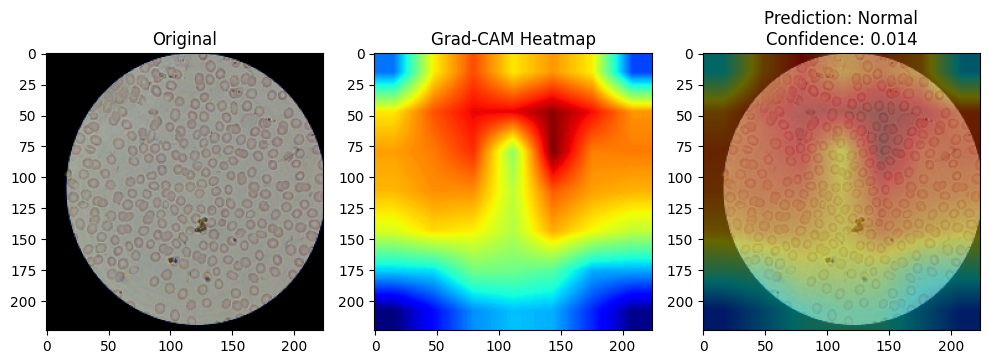

In [81]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pick a sample test image
sample_path = test_df.sample(1).iloc[0]['filepath']
img = load_img(sample_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Make prediction
pred = model.predict(img_array)[0][0]
pred_label = "Sickle" if pred > 0.5 else "Normal"
confidence = round(float(pred), 3)

# Generate Grad-CAM
last_conv_layer_name = 'Conv_1'  # last conv layer in MobileNetV2
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose heatmap on original image
img_orig = cv2.imread(sample_path)
img_orig = cv2.resize(img_orig, (224, 224))
heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {pred_label}\nConfidence: {confidence}")
plt.tight_layout()
plt.show()


**Explanation:**

The left image shows the original input blood smear image.  
The middle image is the Grad-CAM heatmap highlighting the regions most relevant in the model's prediction.  
The right image overlays this heatmap on the original image to visualize where the model focused.

The confidence score tells how sure the model is that the image shows sickle cell disease. A score close to 1 means it is very sure it's **"Sickle,"** and close to 0 means it's **"Normal."**

This helps us understand and trust the model by showing what parts of the image influenced its decision.

### Converting Model to TFLite For Mobile App

In [82]:
%%capture
# Path to save model
tflite_model_path = '/content/drive/MyDrive/CAPSTONE/sickle-dataset/models/sickleclinix_model.tflite'

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")


In [83]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Input shape: {input_details[0]['shape']}")
print(f"Output details: {output_details}")

# Prepare a test image array from sample
test_img = img_array.astype(np.float32)

# Set the tensor to point to the input data
interpreter.set_tensor(input_details[0]['index'], test_img)

# Run inference
interpreter.invoke()

# Get output probabilities
output_data = interpreter.get_tensor(output_details[0]['index'])
print(f"TFLite model prediction output: {output_data}")

predicted_label = "Sickle" if output_data[0][0] > 0.5 else "Normal"
print(f"Predicted label: {predicted_label}")


Input shape: [  1 224 224   3]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 178, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TFLite model prediction output: [[0.01449459]]
Predicted label: Normal


### Testing the **.tflite** model

In [84]:
# Path to TFLite model
tflite_model_path = "/content/drive/MyDrive/CAPSTONE/sickle-dataset/models/sickleclinix_model.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])


Input shape: [  1 224 224   3]


In [85]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    img_array = np.array(img, dtype=np.float32)
    img_array = (img_array / 127.5) - 1.0
    return np.expand_dims(img_array, axis=0), img

def predict_tflite_image(image_path):
    input_data, display_img = preprocess_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = output_data[0][0]

    label = "Sickle" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    plt.imshow(display_img)
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence:.2f})")
    plt.show()

    return label, confidence

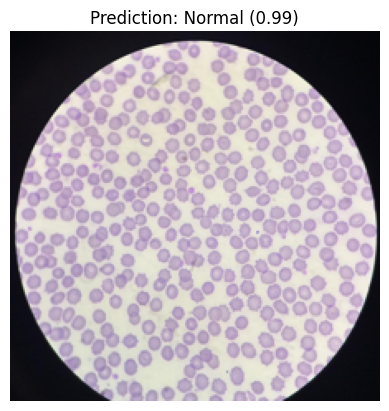

('Normal', np.float32(0.987416))

In [86]:
test_image_1 = "/content/sickle-free.jpg"
test_image_2 = "/content/sickle.jpg"

# Predict
predict_tflite_image(test_image_1)

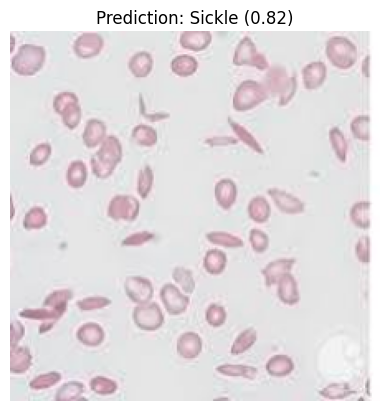

('Sickle', np.float32(0.8232069))

In [87]:
predict_tflite_image(test_image_2)

**References**

Guide to AUC ROC curve in machine learning. (2023). GeeksforGeeks. GeeksforGeeks. [Link to Page](https://www.geeksforgeeks.org/auc-roc-curve/)


Muskan, B. (2021). *Grad-CAM: A Beginner’s Guide*. [Medium Article](https://medium.com/@bmuskan007/grad-cam-a-beginners-guide-adf68e80f4bb)